# Masking data-cubes using geometry objects

In [1]:
import matplotlib.pyplot as plt

from earthkit import transforms as ekt
from earthkit import data as ekd

from earthkit.data.testing import earthkit_remote_test_data_file

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray` or `geopandas` objects.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [2]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
# remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib") # Large file
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_20150101.grib")
era5_data = ekd.from_source("url", remote_era5_file)

# Open as an xarray dataset, renaming the 2m temperature variable to something more manageable
era5_xr = era5_data.to_xarray(time_dim_mode="valid_time").rename({"2t": "t2m"})
era5_xr

era5_temperature_europe_20150101.grib:   0%|          | 0.00/2.59M [00:00<?, ?B/s]

era5_temperature_europe_20150101.grib:  39%|███▊      | 1.00M/2.59M [00:02<00:04, 361kB/s]

era5_temperature_europe_20150101.grib:  77%|███████▋  | 2.00M/2.59M [00:03<00:00, 627kB/s]

era5_temperature_europe_20150101.grib: 100%|██████████| 2.59M/2.59M [00:04<00:00, 813kB/s]

<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 24, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m         (valid_time, latitude, longitude) float64 11MB ...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

In [3]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ekd.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

NUTS_RG_60M_2021_4326_LEVL_0.geojson:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

NUTS_RG_60M_2021_4326_LEVL_0.geojson: 100%|██████████| 68.4k/68.4k [00:00<00:00, 124kB/s]

id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN      NUTS_NAME  MOUNT_TYPE  \
0  DK      DK          0        DK   Danmark        Danmark           0   
1  RS      RS          0        RS    Serbia  Srbija/Сpбија           0   
2  EE      EE          0        EE     Eesti          Eesti           0   
3  EL      EL          0        EL    Elláda         Ελλάδα           0   
4  ES      ES          0        ES    España         España           0   

   URBN_TYPE  COAST_TYPE FID  \
0          0           0  DK   
1          0           0  RS   
2          0           0  EE   
3          0           0  EL   
4          0           0  ES   

                                            geometry  
0  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...  
1  POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....  
2  MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981...  
3  MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92...  
4  MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,...

## Mask dataarray with geodataframe

`shapes.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object the same shape and type as the input xarray object with all points outside of
the geometry masked

In [4]:
single_masked_data = ekt.spatial.mask(era5_xr, nuts_data, union_geometries=True)
single_masked_data

<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 24, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m         (valid_time, latitude, longitude) float64 11MB dask.array<chunksize=(24, 201, 281), meta=np.ndarray>
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

Text(0.5, 1.0, 'Masked data')

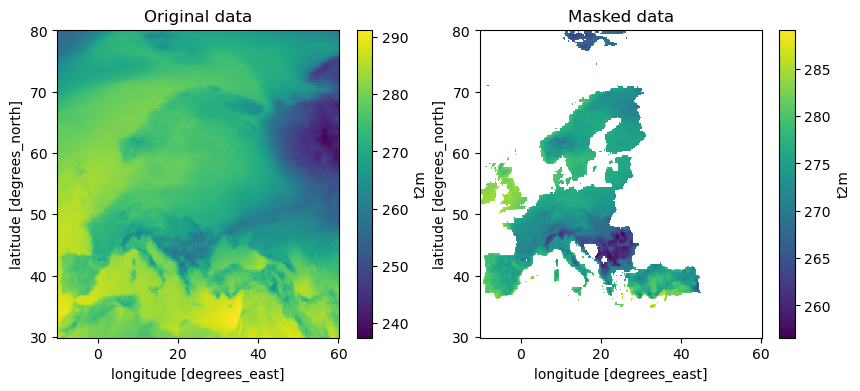

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
era5_xr.t2m.mean(dim='valid_time').plot(ax=axes[0])
axes[0].set_title('Original data')
# Single masked data
single_masked_data.t2m.mean(dim='valid_time').plot(ax=axes[1])
axes[1].set_title('Masked data')

`shapes.masks` applies the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object with an additional dimension, and coordinate variable, corresponding to the 
features in the geometry object.
By default this is the index of the input geodataframe, in this example the index is just an integer
count so it takes the default name `index`.

In [6]:
masked_data = ekt.spatial.mask(era5_xr, nuts_data)
masked_data

<xarray.Dataset> Size: 401MB
Dimensions:     (index: 37, valid_time: 24, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * index       (index) int64 296B 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, valid_time, latitude, longitude) float64 401MB dask.array<chunksize=(1, 24, 201, 281), meta=np.ndarray>
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

It is possible to specify a column in the geodataframe to use for the new dimension, for example in NUTS the
`FID` (= feature id) which contains the two letter identier code for each feature:

In [7]:
masked_data = ekt.spatial.mask(era5_xr, nuts_data, mask_dim="FID")
masked_data

<xarray.Dataset> Size: 401MB
Dimensions:     (FID: 37, valid_time: 24, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * FID         (FID) object 296B 'DK' 'RS' 'EE' 'EL' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m         (FID, valid_time, latitude, longitude) float64 401MB dask.array<chunksize=(1, 24, 201, 281), meta=np.ndarray>
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

Here we demonstrate what we have done by plotting the masked objects we have produced

Text(0.5, 1.0, 'Masked Germany Zoom')

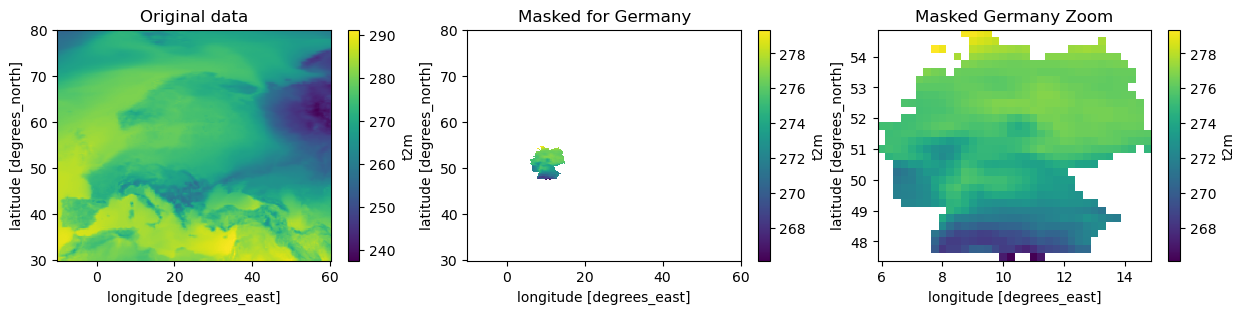

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
era5_xr.t2m.mean(dim='valid_time').plot(ax=axes[0])
axes[0].set_title('Original data')
masked_data.t2m.sel(FID='DE').mean(dim='valid_time').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data.t2m.mean(dim='valid_time').plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')